In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join
import json
import pandas as pd
import pickle
from syllable_cluster import extract_syllables_feature, percentage_change

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib inline

In [2]:
path = '../model/res/super_concurrent_grid_170412_155901/on_alpha_zero_beta+20_replay+default_coef+big_ba+slow_dev+200_conc/'
with open(join(path, 'data_cur.pkl'), 'rb') as f:
    data = pickle.load(f)

In [3]:
root_data = [item[1] for item in data if item[0] == 'root']
rd = pd.DataFrame(root_data)
len(rd)

15

In [4]:
sm = rd.iloc[-1]['songs'][0]

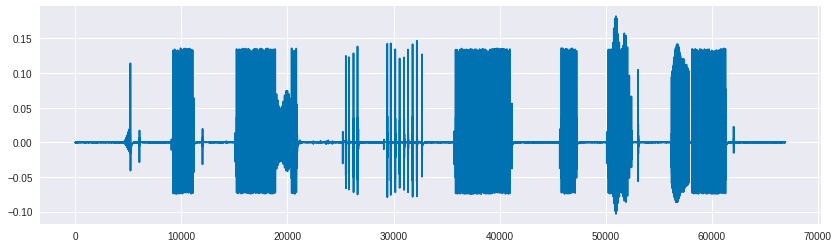

In [5]:
plt.figure(figsize=(14, 4))
plt.plot(sm.gen_sound())
plt.show()

In [6]:
from IPython.display import Audio

Audio(sm.gen_sound(), rate=44100)

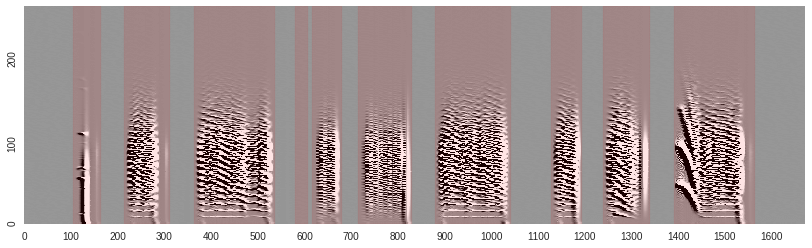

In [7]:
syllables_data = extract_syllables_feature(sm.gen_sound())
fig = plt.figure(figsize=(14, 4))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(bsa.spectral_derivs(sm.gen_sound(), freq_range=256, fft_step=40, fft_size=1024), contrast=0.01, ax=ax)
for syllable in syllables_data:
    ax.axvspan(syllable['beg'], syllable['end'], color='r', alpha=0.1)

In [8]:
out_last = []
for sm in rd.iloc[-1]['songs']:
    out_last += extract_syllables_feature(sm.gen_sound())

syllables_data_last = []
for syllable in out_last:
    syb_dict = {'beg': syllable['beg'],
                'end': syllable['end'],
                'length': syllable['end'] - syllable['beg']}
    for key in syllable:
        if key == 'beg' or key == 'end':
            continue
        syb_dict['m'+key] = np.mean(syllable[key])
        syb_dict['v'+key] = np.var(syllable[key])
    syllables_data_last.append(syb_dict)

out_mid = []
for sm in rd.iloc[len(rd)//2]['songs']:
    out_mid += extract_syllables_feature(sm.gen_sound())

syllables_data_mid = []
for syllable in out_mid:
    syb_dict = {'beg': syllable['beg'],
                'end': syllable['end'],
                'length': syllable['end'] - syllable['beg']}
    for key in syllable:
        if key == 'beg' or key == 'end':
            continue
        syb_dict['m'+key] = np.mean(syllable[key])
        syb_dict['v'+key] = np.var(syllable[key])
    syllables_data_mid.append(syb_dict)

In [9]:
last_dat = pd.DataFrame(syllables_data_last)
last_dat['cond'] = 'last'
mid_dat = pd.DataFrame(syllables_data_mid)
mid_dat['cond'] = 'mid'
all_dat = pd.concat((last_dat, mid_dat))

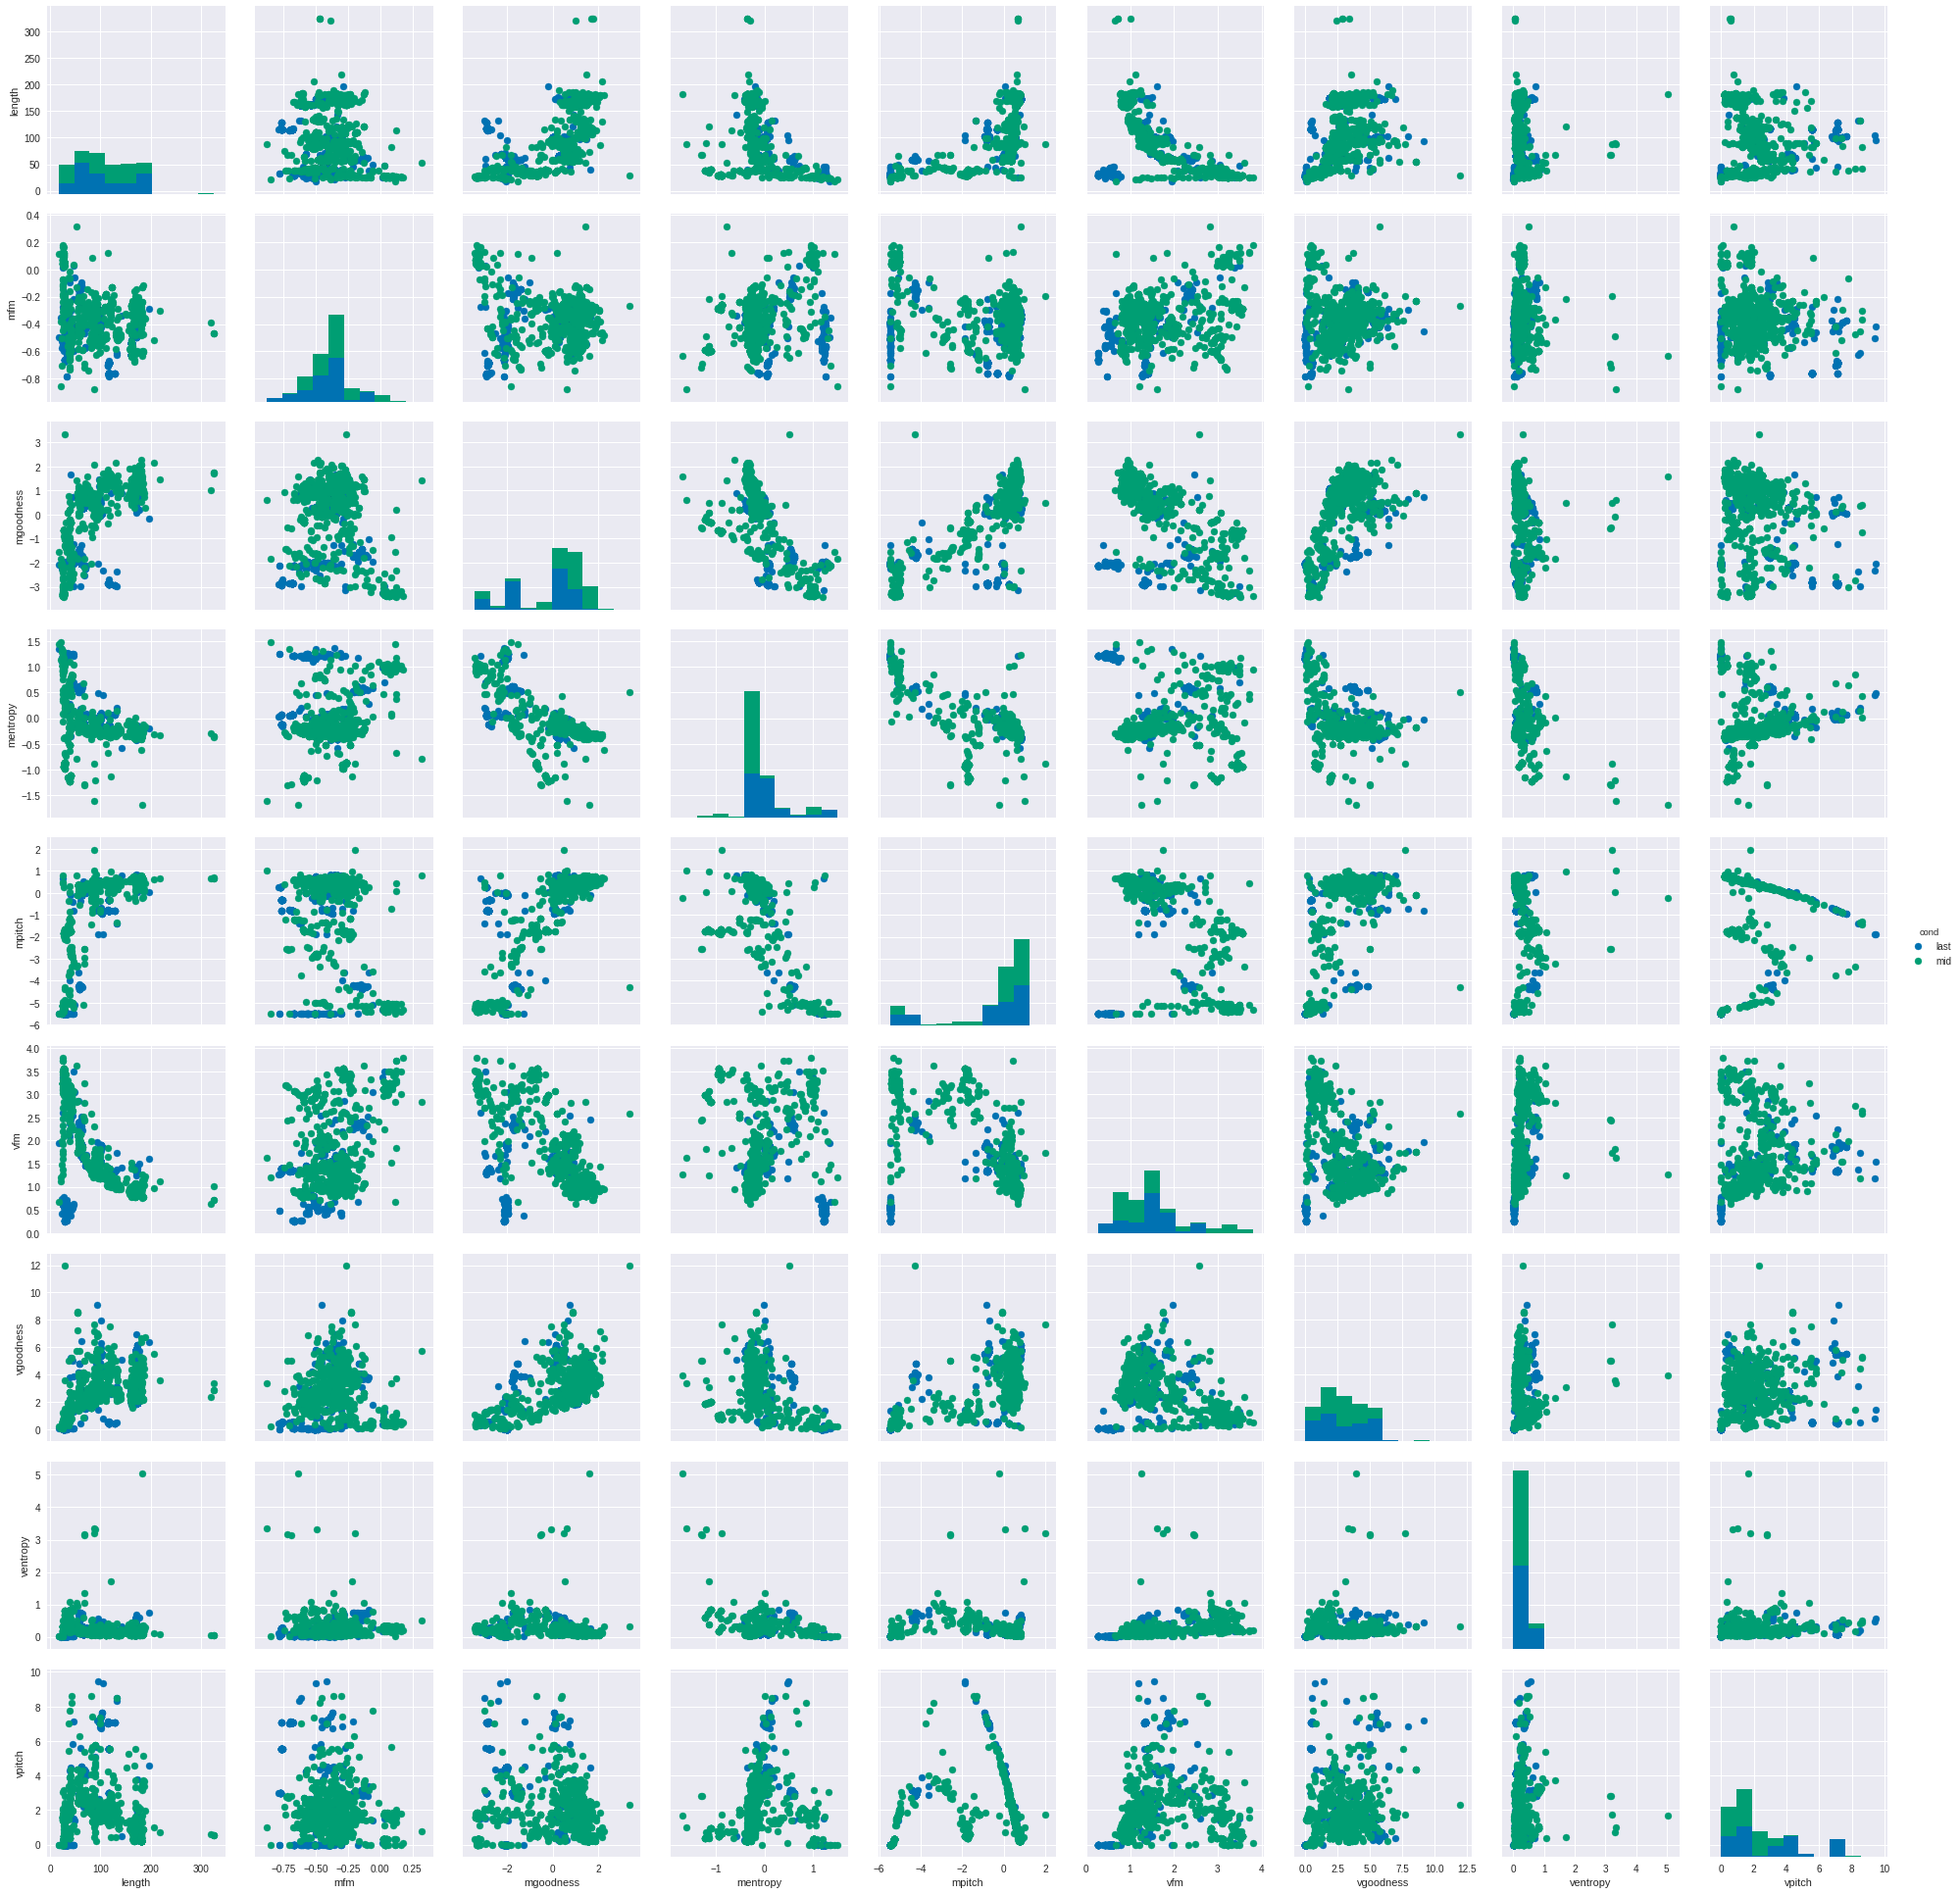

In [10]:
g = sns.PairGrid(all_dat, hue="cond", vars=['length', 'mfm', 'mgoodness', 'mentropy', 'mpitch',
                                            'vfm', 'vgoodness', 'ventropy', 'vpitch'], size=3)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

In [14]:
percentage_change(mid_dat, last_dat)

beg             0.140252
end             0.120337
length          0.000000
mam            36.607403
mamplitude    210.773889
mentropy       63.097222
mfm            16.258311
mgoodness      90.466814
mpitch         92.146153
vam            46.010125
vamplitude     16.275365
ventropy        6.023844
vfm             6.552565
vgoodness       4.379076
vpitch         79.411254
dtype: float64